In [29]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
from torch.optim import Adam

In [30]:
T = 200
IMAGE_SIZE = 64
BATCH_SIZE = 128
EPOCHS = 100
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [31]:
def cosine_beta_schedule(timestep, start=0.0001, end=0.02):
    t = torch.linspace(0, 1, timestep, device=DEVICE)
    alphas_cumprod = torch.cos((t + 0.008) / 1.008 * math.pi / 2) ** 2
    betas = 1 - alphas_cumprod / torch.cat([torch.tensor([1.0], device=DEVICE), alphas_cumprod[:-1]])
    betas = start + (end - start) * (betas - betas.min()) / (betas.max() - betas.min())
    return betas.clamp(start, end)

In [32]:
betas = cosine_beta_schedule(timestep=T)
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

In [33]:
def get_data_transforms(image_size=IMAGE_SIZE):
    return transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Lambda(lambda t: (t * 2.) - 1),
    ])

def load_transformed_dataset(folder_path='images', image_size=IMAGE_SIZE):
    data_transform = get_data_transforms(image_size)
    dataset = CustomImageDataset(folder_path=folder_path, transform=data_transform)
    return dataset

def show_tensor_image(image):
    reverse_transform = transforms.Compose([
        transforms.Lambda(lambda t: (t + 1.) / 2.),
        transforms.Lambda(lambda t: t.permute(1, 2, 0)),
        transforms.Lambda(lambda t: t * 255),
        transforms.Lambda(lambda t: t.cpu().numpy().astype(np.uint8)),
        transforms.ToPILImage()
    ])
    if len(image.shape) == 4:
        image = image[0]
    plt.imshow(reverse_transform(image))
    plt.axis('off')
    plt.show()

In [34]:
class CustomImageDataset(Dataset):
    def __init__(self, folder_path, transform=None):
        self.folder_path = folder_path
        self.transform = transform
        self.image_files = [f for f in os.listdir(folder_path)
                           if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.gif'))]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.folder_path, self.image_files[idx])
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, 0

In [35]:
def get_index_from_list(vals, t, x_shape):
    batch_size = t.shape[0]
    out = vals.gather(-1, t)
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1)))

def forward_diffusion_sample(x_0, t, device=DEVICE):
    noise = torch.randn_like(x_0)
    sqrt_alphas_cumprod_t = get_index_from_list(sqrt_alphas_cumprod, t, x_0.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(sqrt_one_minus_alphas_cumprod, t, x_0.shape)
    return (
        sqrt_alphas_cumprod_t * x_0 +
        sqrt_one_minus_alphas_cumprod_t * noise,
        noise
    )


In [36]:
class SimpleUNet(nn.Module):
    def __init__(self):
        super(SimpleUNet, self).__init__()
        self.down1 = nn.Conv2d(3, 64, 3, padding=1)
        self.down2 = nn.Conv2d(64, 128, 3, padding=1)
        self.up1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.up2 = nn.Conv2d(64 + 64, 3, 3, padding=1)
        self.time_emb = nn.Embedding(T, 128)

    def forward(self, x, t):
        t_emb = self.time_emb(t).unsqueeze(-1).unsqueeze(-1)
        x1 = F.relu(self.down1(x))
        x2 = F.max_pool2d(F.relu(self.down2(x1)), 2)
        x_up = F.relu(self.up1(x2))
        x_up = torch.cat([x_up, x1[:, :, :x_up.shape[2], :x_up.shape[3]]], dim=1)
        return self.up2(x_up + t_emb)

In [37]:
def get_loss(model, x_0, t):
    x_noisy, noise = forward_diffusion_sample(x_0, t)
    noise_pred = model(x_noisy, t)
    return F.mse_loss(noise_pred, noise)

def sample_plot_image():
    model.eval()
    with torch.no_grad():
        x = torch.randn(1, 3, IMAGE_SIZE, IMAGE_SIZE, device=DEVICE)
        for i in reversed(range(T)):
            t = torch.full((1,), i, device=DEVICE, dtype=torch.long)
            noise_pred = model(x, t)
            alpha_t = alphas[t].unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)
            alpha_cumprod_t = alphas_cumprod[t].unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)
            beta_t = betas[t].unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)
            x = (1 / torch.sqrt(alpha_t)) * (x - ((1 - alpha_t) / torch.sqrt(1 - alpha_cumprod_t)) * noise_pred)
            if i > 0:
                x += torch.sqrt(beta_t) * torch.randn_like(x)
        show_tensor_image(x.clamp(-1, 1))
    model.train()

Epoch 0 | step 000 Loss: 1.302319049835205


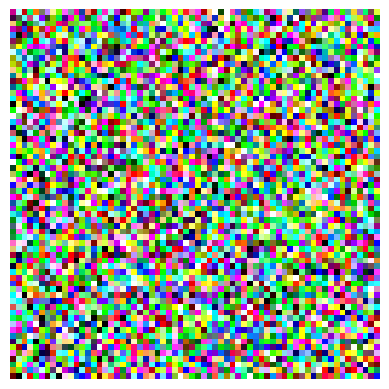

Epoch 5 | step 000 Loss: 0.51065993309021


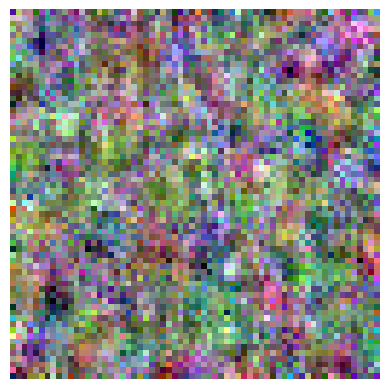

Epoch 10 | step 000 Loss: 0.3574672341346741


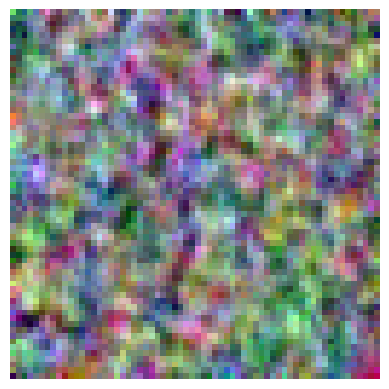

Epoch 15 | step 000 Loss: 0.33993518352508545


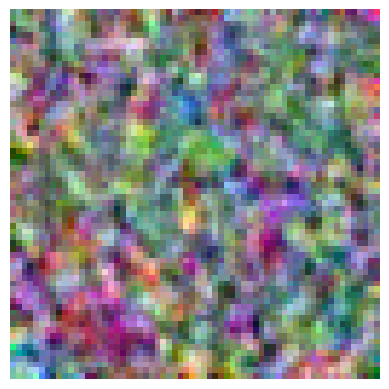

Epoch 20 | step 000 Loss: 0.31261858344078064


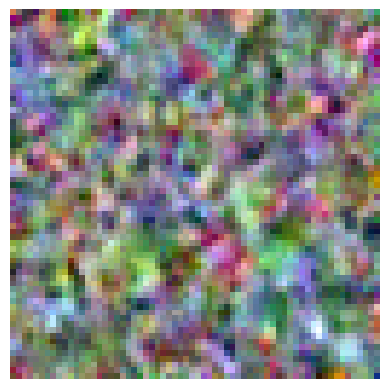

Epoch 25 | step 000 Loss: 0.30774298310279846


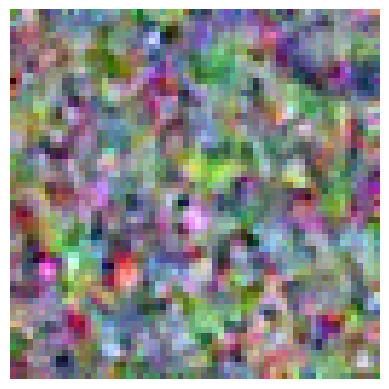

Epoch 30 | step 000 Loss: 0.29323700070381165


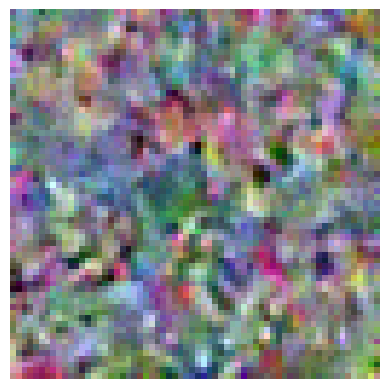

Epoch 35 | step 000 Loss: 0.32223936915397644


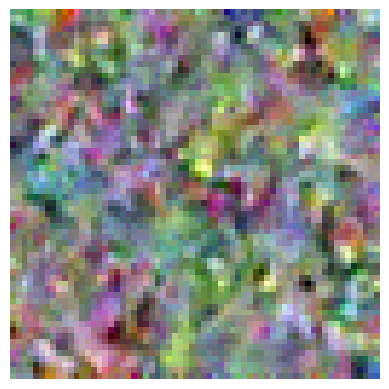

Epoch 40 | step 000 Loss: 0.29871195554733276


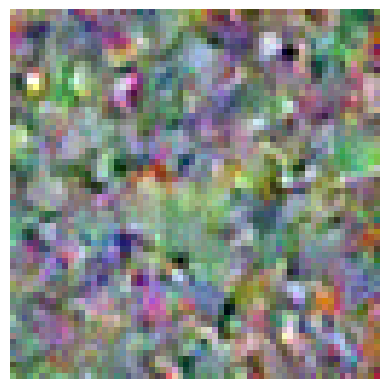

Epoch 45 | step 000 Loss: 0.29677700996398926


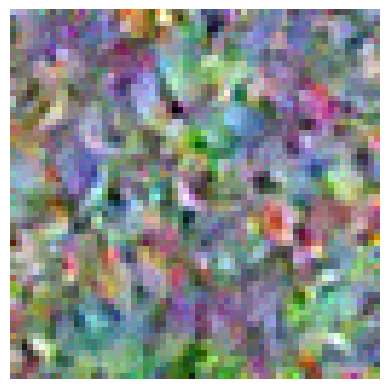

Epoch 50 | step 000 Loss: 0.31055742502212524


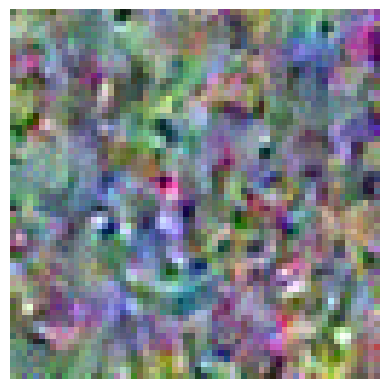

Epoch 55 | step 000 Loss: 0.2623700797557831


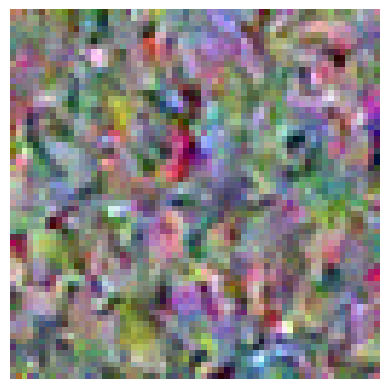

Epoch 60 | step 000 Loss: 0.28985679149627686


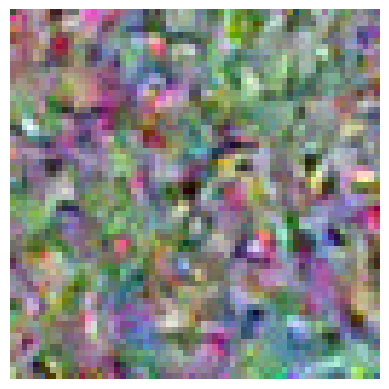

Epoch 65 | step 000 Loss: 0.2978963255882263


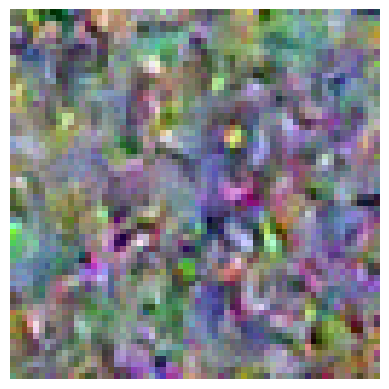

Epoch 70 | step 000 Loss: 0.2706751823425293


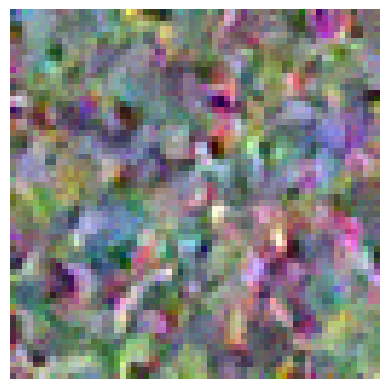

Epoch 75 | step 000 Loss: 0.26521918177604675


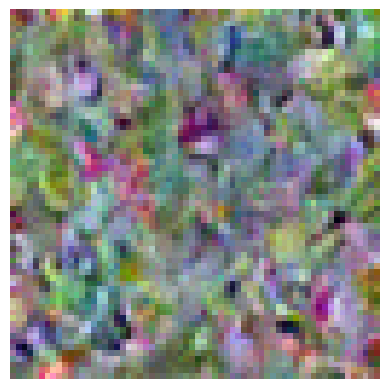

Epoch 80 | step 000 Loss: 0.2840966582298279


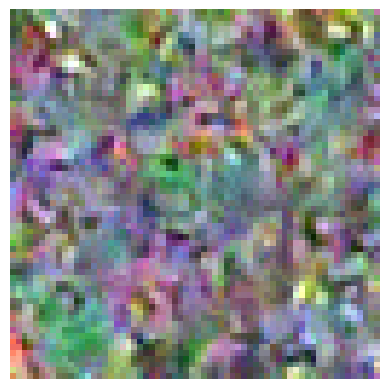

Epoch 85 | step 000 Loss: 0.2896919250488281


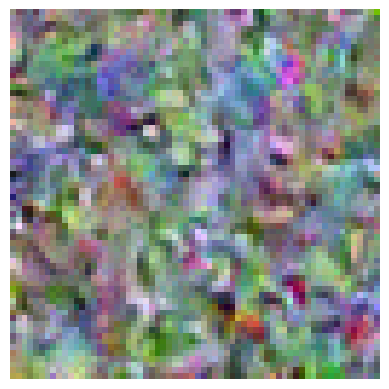

Epoch 90 | step 000 Loss: 0.30811601877212524


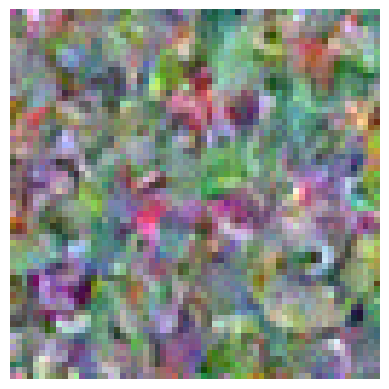

Epoch 95 | step 000 Loss: 0.3036641776561737


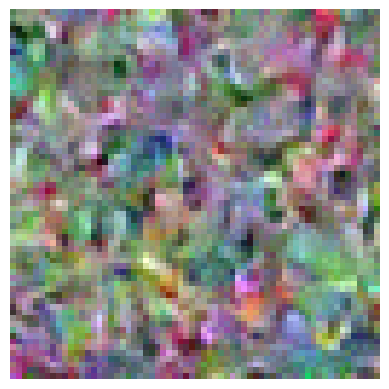

In [39]:
if __name__ == "__main__":
    data = load_transformed_dataset(folder_path='images')
    data_loader = DataLoader(data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

    model = SimpleUNet().to(DEVICE)
    optimizer = Adam(model.parameters(), lr=0.001)

    for epoch in range(EPOCHS):
        for step, batch in enumerate(data_loader):
            optimizer.zero_grad()
            t = torch.randint(0, T, (BATCH_SIZE,), device=DEVICE).long()
            loss = get_loss(model, batch[0].to(DEVICE), t)
            loss.backward()
            optimizer.step()

            if epoch % 5 == 0 and step == 0:
                print(f"Epoch {epoch} | step {step:03d} Loss: {loss.item()}")
                sample_plot_image()